In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import time
import scipy.stats as st
from scipy.stats import linregress
import gmaps
import datetime
from datetime import date

# Google developer API key
from config import g_key

# Configure gmaps
gmaps.configure(api_key=g_key)

### Data organization process

In [2]:
# Study data files
fire_data_path = 'Resources/California_Fire_Incidents.csv'
ca_county_path = 'Resources/County_CA.csv'

# Read in csv file
fire_df = pd.read_csv(fire_data_path)
ca_county_df = pd.read_csv(ca_county_path)

# Combine the data into a single dataset
merged_fire_df = pd.merge(ca_county_df, fire_df, how='left', left_on = 'Counties', right_on = 'Counties')
merged_fire_df.head()

,Counties,AcresBurned,Active,AdminUnit,AirTankers,ArchiveYear,CalFireIncident,CanonicalUrl,ConditionStatement,ControlStatement,...,Started,Time.1,Status,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,UniqueId,Updated,WaterTenders
0,Alameda,240.0,False,CAL FIRE Santa Clara Unit,NaN,2013.0,True,/incidents/2013/6/8/vasco-fire/,NaN,NaN,...,6/8/13,10:16:00Z,Finalized,NaN,NaN,NaN,NaN,2ad509e4-99f1-4e1a-81eb-839f772f9c45,2013-06-08T13:25:00Z,NaN
1,Alameda,150.0,False,CAL FIRE Santa Clara Unit,NaN,2013.0,True,/incidents/2013/10/4/highland-fire/,NaN,NaN,...,10/4/13,07:35:00Z,Finalized,NaN,NaN,NaN,NaN,6a48000a-6198-46dd-9a91-0b0159183145,2013-10-04T10:30:00Z,NaN
2,Alameda,50.0,False,CAL FIRE Santa Clara Unit,NaN,2013.0,True,/incidents/2013/7/4/grant-fire/,NaN,NaN,...,7/4/13,10:00:00Z,Finalized,NaN,NaN,NaN,NaN,07fb8b11-f39b-4cd0-8a27-2d4fef7fe680,2013-07-04T11:30:00Z,NaN
3,Alameda,38.0,False,CAL FIRE Santa Clara Unit / Alameda County Fire,NaN,2013.0,True,/incidents/2013/7/6/fallon-fire/,NaN,NaN,...,7/6/13,13:09:00Z,Finalized,NaN,NaN,NaN,NaN,4c04a4e5-f580-4e62-bb53-2575c72d29dc,2013-07-06T14:30:00Z,NaN
4,Alameda,2700.0,False,CAL FIRE Santa Clara Unit,NaN,2015.0,True,/incidents/2015/8/19/tesla-fire/,Unit is now in control of incident.,NaN,...,8/19/15,14:45:00Z,Finalized,NaN,NaN,NaN,NaN,8fc920eb-ca45-4d77-9a92-1326eca602d6,2015-08-22T18:30:00Z,1.0


In [3]:
# Clean data
ca_fire_df = merged_fire_df.drop(columns=[
    "Active", 
    "CanonicalUrl", 
    "ConditionStatement", 
    "FuelType", 
    "Location", 
    "ControlStatement", 
    "CalFireIncident", 
    "AdminUnit", 
    "PercentContained", 
    "Time.1", 
    "Time", 
    "Status", 
    "SearchDescription", 
    "SearchKeywords", 
    "Public", 
    "Updated"], inplace=False)

# Get only month data in each row
fire_start = ca_fire_df['Started']
fire_start_list = list(fire_start)
months = []

for d in range(len(fire_start_list)):
    try:
        date = fire_start_list[d].split('/')
        month = date[0]
        months.append(str(month))
    except:
        months.append(None)

# apply average value for duplicated fire incidents
id_count = ca_fire_df['UniqueId'].value_counts().to_frame().reset_index()
uid_count = id_count.loc[id_count['UniqueId'] > 1]
df_index = []

for i in uid_count['index']:
    index = ca_fire_df[ca_fire_df['UniqueId']==i].index
    for x in index:
        ca_fire_df.loc[x, ['AcresBurned', 
                           'Dozers',
                           'Engines', 
                           'PersonnelInvolved', 
                           'WaterTenders']] = ca_fire_df.loc[x, ['AcresBurned',
                                                                 'Dozers',
                                                                 'Engines', 
                                                                 'PersonnelInvolved', 
                                                                 'WaterTenders']].div(len(index))
        
ca_fire_df['Started Month'] = months

# Converting dtypes
ca_fire_df['ArchiveYear'] = ca_fire_df['ArchiveYear'].map('{:.0f}'.format)

# Store clean data in csv file
ca_fire_df.to_csv('output_data/california_fire_cleaned.csv', index=False, header=True)
ca_fire_df.head()

,Counties,AcresBurned,AirTankers,ArchiveYear,CountyIds,CrewsInvolved,Dozers,Engines,Extinguished,Days Burned,...,Name,PersonnelInvolved,Started,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,UniqueId,WaterTenders,Started Month
0,Alameda,240.0,NaN,2013,1,NaN,NaN,NaN,6/8/13,0.0,...,Vasco Fire,NaN,6/8/13,NaN,NaN,NaN,NaN,2ad509e4-99f1-4e1a-81eb-839f772f9c45,NaN,6
1,Alameda,150.0,NaN,2013,1,NaN,NaN,NaN,10/4/13,0.0,...,Highland Fire,NaN,10/4/13,NaN,NaN,NaN,NaN,6a48000a-6198-46dd-9a91-0b0159183145,NaN,10
2,Alameda,50.0,NaN,2013,1,NaN,NaN,NaN,7/4/13,0.0,...,Grant Fire,NaN,7/4/13,NaN,NaN,NaN,NaN,07fb8b11-f39b-4cd0-8a27-2d4fef7fe680,NaN,7
3,Alameda,38.0,NaN,2013,1,NaN,NaN,NaN,7/6/13,0.0,...,Fallon Fire,NaN,7/6/13,NaN,NaN,NaN,NaN,4c04a4e5-f580-4e62-bb53-2575c72d29dc,NaN,7
4,Alameda,2700.0,NaN,2015,1,NaN,NaN,5.0,8/22/15,3.0,...,Tesla Fire,18.0,8/19/15,NaN,NaN,NaN,NaN,8fc920eb-ca45-4d77-9a92-1326eca602d6,1.0,8


**Major fire incidents**

*Burned area more than 10 arces*

In [4]:
# Major fire incident
major_fire_df = ca_fire_df.loc[ca_fire_df['MajorIncident']==True]

# Store clean data in csv file
major_fire_df.to_csv('output_data/major_fire.csv', index=False, header=True)
major_fire_df.head()

,Counties,AcresBurned,AirTankers,ArchiveYear,CountyIds,CrewsInvolved,Dozers,Engines,Extinguished,Days Burned,...,Name,PersonnelInvolved,Started,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,UniqueId,WaterTenders,Started Month
4,Alameda,2700.0,NaN,2015,1,NaN,NaN,5.0,8/22/15,3.0,...,Tesla Fire,18.0,8/19/15,NaN,NaN,NaN,NaN,8fc920eb-ca45-4d77-9a92-1326eca602d6,1.0,8
15,Alameda,640.0,NaN,2018,1,NaN,NaN,NaN,1/4/19,180.0,...,Grant Fire,NaN,7/8/18,NaN,NaN,NaN,NaN,d0e1cdc0-9dea-467a-8ae8-040e0f94178d,NaN,7
35,Amador,2120.0,NaN,2014,3;9,1.0,NaN,1.5,8/2/14,8.0,...,Sand Fire,20.0,7/25/14,NaN,67.0,NaN,NaN,4d07ccc3-32be-4a1d-acac-18333884c97d,0.5,7
36,Amador,355.0,NaN,2015,3,1.0,2.0,13.0,7/2/15,0.0,...,Ione Fire,NaN,7/2/15,NaN,NaN,NaN,NaN,c3f64286-b2a0-4ab1-9f6b-d934d5b82228,5.0,7
39,Amador,210.0,NaN,2016,3,NaN,NaN,NaN,6/21/16,4.0,...,Camanche Fire,NaN,6/17/16,NaN,NaN,NaN,NaN,fef2ab8a-20d7-4dc3-b5c9-363aa1debef3,NaN,6


## Pyres California Summary

In [5]:
# All fire incidents
fire_mean = ca_fire_df.groupby('Counties')['AcresBurned'].mean()
fire_median = ca_fire_df.groupby('Counties')['AcresBurned'].median()
fire_variance = ca_fire_df.groupby('Counties')['AcresBurned'].var()
fire_standard_dv = ca_fire_df.groupby('Counties')['AcresBurned'].std()
fire_sem = ca_fire_df.groupby('Counties')['AcresBurned'].sem()

# Create a dataframe to hold the result
fire_summary_df = pd.DataFrame({"Acres Burned Mean": fire_mean, 
                                "Acres Burned Median": fire_median, 
                                "Acres Burned VAR": fire_variance, 
                                "Acres Burned STD": fire_standard_dv,
                                "Acres Burned SEM": fire_sem
                                })
                                    
# Give the displayed data cleaner formatting
fire_summary_df["Acres Burned Mean"] = fire_summary_df["Acres Burned Mean"].map('{:,.2f}'.format)
fire_summary_df["Acres Burned Median"] = fire_summary_df["Acres Burned Median"].map('{:,.2f}'.format)
fire_summary_df["Acres Burned STD"] = fire_summary_df["Acres Burned STD"].map('{:,.2f}'.format)
fire_summary_df["Acres Burned SEM"] = fire_summary_df["Acres Burned SEM"].map('{:,.2f}'.format)

# Present data
fire_summary_df.head()

,Acres Burned Mean,Acres Burned Median,Acres Burned VAR,Acres Burned STD,Acres Burned SEM
Counties,,,,,
Alameda,199.59,46.50,2.292581e+05,478.81,84.64
Alpine,0.00,0.00,0.000000e+00,0.00,0.00
Amador,320.38,60.00,3.471249e+05,589.17,163.41
Butte,"2,889.42",89.50,3.559001e+08,"18,865.31","2,322.16"
Calaveras,120.36,81.50,1.406196e+04,118.58,25.28


In [6]:
# Calculation
mj_burn_mean = major_fire_df.groupby('Counties')['AcresBurned'].mean()
mj_burn_median = major_fire_df.groupby('Counties')['AcresBurned'].median()
mj_burn_variance = major_fire_df.groupby('Counties')['AcresBurned'].var()
mj_burn_standard_dv = major_fire_df.groupby('Counties')['AcresBurned'].std()
mj_burn_sem = major_fire_df.groupby('Counties')['AcresBurned'].sem()

# Create a dataframe to hold the result
mj_burn_summary_df = pd.DataFrame({"Acres Burned Mean": mj_burn_mean, 
                                   "Acres Burned Median": mj_burn_median, 
                                   "Acres Burned VAR": mj_burn_variance, 
                                   "Acres Burned STD": mj_burn_standard_dv,
                                   "Acres Burned SEM": mj_burn_sem
                                  })
                                    
# Give the displayed data cleaner formatting
mj_burn_summary_df["Acres Burned Mean"] = mj_burn_summary_df["Acres Burned Mean"].map('{:,.2f}'.format)
mj_burn_summary_df["Acres Burned Median"] = mj_burn_summary_df["Acres Burned Median"].map('{:,.2f}'.format)
mj_burn_summary_df["Acres Burned STD"] = mj_burn_summary_df["Acres Burned STD"].map('{:,.2f}'.format)
mj_burn_summary_df["Acres Burned SEM"] = mj_burn_summary_df["Acres Burned SEM"].map('{:,.2f}'.format)

# Present data
mj_burn_summary_df.head()

,Acres Burned Mean,Acres Burned Median,Acres Burned VAR,Acres Burned STD,Acres Burned SEM
Counties,,,,,
Alameda,"1,670.00","1,670.00",2.121800e+06,"1,456.64","1,030.00"
Amador,451.25,127.50,5.313285e+05,728.92,257.71
Butte,"6,531.11",224.00,8.323339e+08,"28,850.20","5,452.17"
Calaveras,122.10,84.00,1.404010e+04,118.49,37.47
Colusa,"19,838.24",72.50,1.684248e+09,"41,039.59","16,754.34"


Counties
Riverside          146
San Diego           89
Butte               66
San Luis Obispo     64
Shasta              64
Kern                62
Fresno              57
Siskiyou            57
San Bernardino      53
Tehama              51
Name: UniqueId, dtype: int64


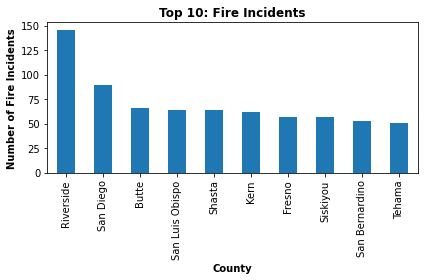

In [7]:
#Top ten counties for all fire incidents
all_top_10_df = ca_fire_df.groupby('Counties')['UniqueId'].count().sort_values(ascending=False)
all_top_ten_counties = all_top_10_df.head(10)

# Generate a bar plot
all_top10_bar = all_top_ten_counties.plot(kind="bar", legend=False)

# Set x/y label, title
all_top10_bar.set_title(label='Top 10: Fire Incidents', fontweight = 'bold')
all_top10_bar.set_xlabel('County', fontweight = 'bold')
all_top10_bar.set_ylabel('Number of Fire Incidents', fontweight = 'bold')

# Save bar graph to Images folder
plt.tight_layout()
all_top10_bar.figure.savefig('Images/bar_top_ca_all_fire.png')

# Present the bar chart with data
print(all_top_ten_counties)
plt.show()

# To close pyplot
plt.close()

Counties
San Francisco    0
Imperial         0
Alpine           2
Sierra           2
Sutter           3
San Mateo        3
Santa Cruz       4
Kings            5
Marin            6
Colusa           6
Name: UniqueId, dtype: int64


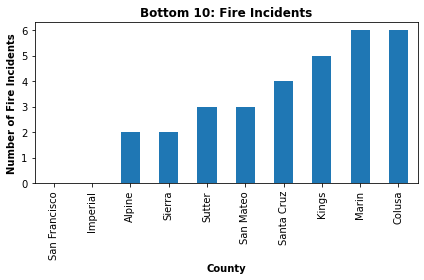

In [8]:
# Bottom ten counties for all fire incidents
all_bottom_10_df = ca_fire_df.groupby('Counties')['UniqueId'].count().sort_values(ascending=True)
all_bottom_ten_counties = all_bottom_10_df.head(10)

# Generate a bar plot
all_bottom10_bar = all_bottom_ten_counties.plot(kind="bar", legend=False)

# Set x/y label, title
all_bottom10_bar.set_title(label='Bottom 10: Fire Incidents', fontweight = 'bold')
all_bottom10_bar.set_xlabel('County', fontweight = 'bold')
all_bottom10_bar.set_ylabel('Number of Fire Incidents', fontweight = 'bold')

# Save bar graph to Images folder
plt.tight_layout()
all_bottom10_bar.figure.savefig('Images/bar_bottom_ca_all_fire.png')

# Present the bar chart with data
print(all_bottom_ten_counties)
plt.show()

# To close pyplot
plt.close()

Counties
Siskiyou         367914.000000
Trinity          334567.000000
Shasta           302046.000000
Tuolumne         299132.000000
Ventura          236710.000000
Lake             227788.416667
Santa Barbara    221621.500000
Mariposa         217852.000000
Fresno           214411.000000
Butte            190702.000000
Name: AcresBurned, dtype: float64


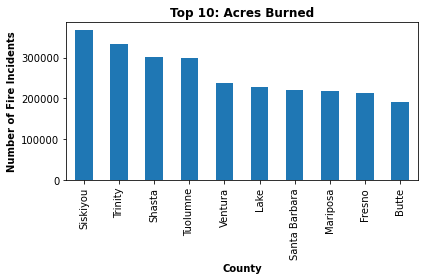

In [9]:
#Top ten counties for all fire incidents
area_all_top_10_df = ca_fire_df.groupby('Counties')['AcresBurned'].sum().sort_values(ascending=False)
area_all_top_ten_counties = area_all_top_10_df.head(10)

# Generate a bar plot
area_all_top10_bar = area_all_top_ten_counties.plot(kind="bar", legend=False)

# Set x/y label, title
area_all_top10_bar.set_title(label='Top 10: Acres Burned', fontweight = 'bold')
area_all_top10_bar.set_xlabel('County', fontweight = 'bold')
area_all_top10_bar.set_ylabel('Number of Fire Incidents', fontweight = 'bold')

# Save bar graph to Images folder
plt.tight_layout()
area_all_top10_bar.figure.savefig('Images/bar_top_ca_area_all_fire.png')

# Present the bar chart with data
print(area_all_top_ten_counties)
plt.show()

# To close pyplot
plt.close()

Counties
Alpine              0.0
San Francisco       0.0
Imperial            0.0
San Mateo         153.0
Marin             349.0
Santa Cruz        428.0
Sierra            915.0
Sacramento       1903.5
Calaveras        2648.0
Sutter           2850.0
Name: AcresBurned, dtype: float64


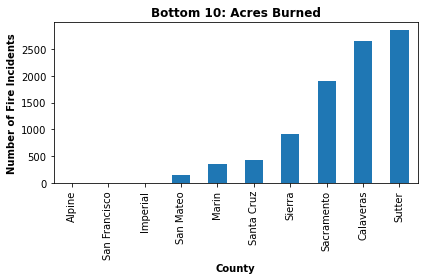

In [10]:
# Bottom ten counties for all fire incidents (area burned)
all_bottom_ten_area_df = ca_fire_df.groupby('Counties')['AcresBurned'].sum().sort_values(ascending=True)
all_bottom_ten_area_counties = all_bottom_ten_area_df.head(10)

# Generate a bar plot
all_bottom_ten_area_counties_bar = all_bottom_ten_area_counties.plot(kind="bar", legend=False)

# Set x/y label, title
all_bottom_ten_area_counties_bar.set_title(label='Bottom 10: Acres Burned', fontweight = 'bold')
all_bottom_ten_area_counties_bar.set_xlabel('County', fontweight = 'bold')
all_bottom_ten_area_counties_bar.set_ylabel('Number of Fire Incidents', fontweight = 'bold')

# Save bar graph to Images folder
plt.tight_layout()
all_bottom_ten_area_counties_bar.figure.savefig('Images/bar_bottom_ca_area all_fire.png')

# Present the bar chart with data
print(all_bottom_ten_area_counties)
plt.show()

# To close pyplot
plt.close()

### Major fire incidents 

In [11]:
# Calculation
mj_burn_mean = major_fire_df.groupby('Counties')['AcresBurned'].mean()
mj_burn_median = major_fire_df.groupby('Counties')['AcresBurned'].median()
mj_burn_variance = major_fire_df.groupby('Counties')['AcresBurned'].var()
mj_burn_standard_dv = major_fire_df.groupby('Counties')['AcresBurned'].std()
mj_burn_sem = major_fire_df.groupby('Counties')['AcresBurned'].sem()

# Create a dataframe to hold the result
mj_burn_summary_df = pd.DataFrame({"Acres Burned Mean": mj_burn_mean, 
                                   "Acres Burned Median": mj_burn_median, 
                                   "Acres Burned VAR": mj_burn_variance, 
                                   "Acres Burned STD": mj_burn_standard_dv,
                                   "Acres Burned SEM": mj_burn_sem
                                  })
                                    
# Give the displayed data cleaner formatting
mj_burn_summary_df["Acres Burned Mean"] = mj_burn_summary_df["Acres Burned Mean"].map('{:,.2f}'.format)
mj_burn_summary_df["Acres Burned Median"] = mj_burn_summary_df["Acres Burned Median"].map('{:,.2f}'.format)
mj_burn_summary_df["Acres Burned STD"] = mj_burn_summary_df["Acres Burned STD"].map('{:,.2f}'.format)
mj_burn_summary_df["Acres Burned SEM"] = mj_burn_summary_df["Acres Burned SEM"].map('{:,.2f}'.format)

# Present data
mj_burn_summary_df.head()

,Acres Burned Mean,Acres Burned Median,Acres Burned VAR,Acres Burned STD,Acres Burned SEM
Counties,,,,,
Alameda,"1,670.00","1,670.00",2.121800e+06,"1,456.64","1,030.00"
Amador,451.25,127.50,5.313285e+05,728.92,257.71
Butte,"6,531.11",224.00,8.323339e+08,"28,850.20","5,452.17"
Calaveras,122.10,84.00,1.404010e+04,118.49,37.47
Colusa,"19,838.24",72.50,1.684248e+09,"41,039.59","16,754.34"


Counties
Butte        28
San Diego    27
Shasta       26
Lake         21
Riverside    18
Napa         16
El Dorado    15
Mariposa     14
Fresno       12
Tehama       11
Name: UniqueId, dtype: int64


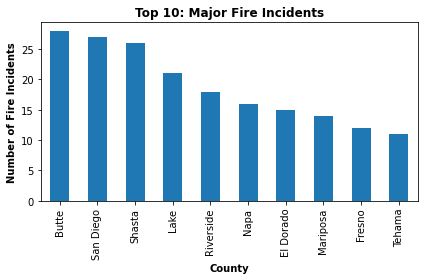

In [12]:
#Top ten counties for major fire incidents
mj_top_10_df = major_fire_df.groupby('Counties')['UniqueId'].count().sort_values(ascending=False)
mj_top_ten_counties = mj_top_10_df.head(10)

# Generate a bar plot
mj_top10_bar = mj_top_ten_counties.plot(kind="bar", legend=False)

# Set x/y label, title
mj_top10_bar.set_title(label='Top 10: Major Fire Incidents', fontweight = 'bold')
mj_top10_bar.set_xlabel('County', fontweight = 'bold')
mj_top10_bar.set_ylabel('Number of Fire Incidents', fontweight = 'bold')

# Save bar graph to Images folder
plt.tight_layout()
mj_top10_bar.figure.savefig('Images/bar_top_ca_mj_fire.png')

# Present the bar chart with data
print(mj_top_ten_counties)
plt.show()

# To close pyplot
plt.close()

Counties
San Mateo      1
Sacramento     1
Orange         1
Mono           1
Merced         1
Marin          1
Kings          1
Alameda        2
Santa Cruz     2
Santa Clara    2
Name: UniqueId, dtype: int64


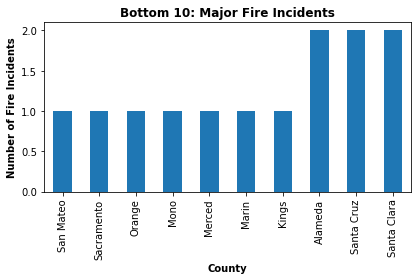

In [13]:
# Find last ten counties for major fire incidents
mj_bottom_10_df = major_fire_df.groupby('Counties')['UniqueId'].count().sort_values(ascending=True)
mj_last_ten_counties = mj_bottom_10_df.head(10)


# Generate a bar plot
mj_bottom10_bar = mj_last_ten_counties.plot(kind="bar", legend=False)

# Set x/y label, title
mj_bottom10_bar.set_title(label='Bottom 10: Major Fire Incidents', fontweight = 'bold')
mj_bottom10_bar.set_xlabel('County', fontweight = 'bold')
mj_bottom10_bar.set_ylabel('Number of Fire Incidents', fontweight = 'bold')

# Save bar graph to Images folder
plt.tight_layout()
mj_top10_bar.figure.savefig('Images/bar_bottom_ca_mj_fire.png')

# Present the bar chart with data
print(mj_last_ten_counties)
plt.show()

# To close pyplot
plt.close()

### Pattern

In [14]:
# Change data type and sort by month
fire_trend_df = ca_fire_df.dropna(how='any', subset=['Started Month'])
fire_trend = fire_trend_df.astype({'Started Month': 'int64', 'ArchiveYear' : 'int64'}).sort_values('Started Month', ascending=True)

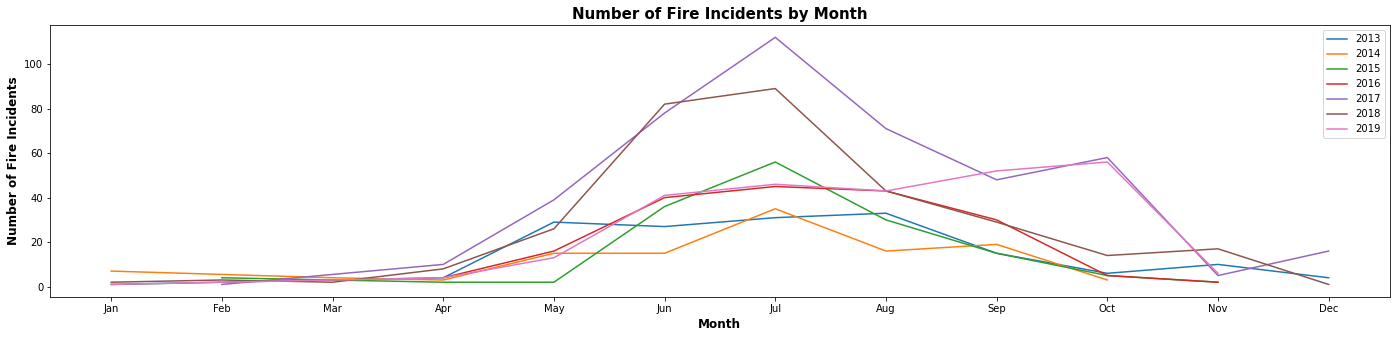

In [16]:
# Generating line chart for each year 
fire_trend_2013 = fire_trend.loc[fire_trend['ArchiveYear'] == 2013]
fire_per_month_2013 = fire_trend_2013['Started Month'].value_counts().sort_index()
plot_2013, = plt.plot(fire_per_month_2013)

fire_trend_2014 = fire_trend.loc[fire_trend['ArchiveYear'] == 2014]
fire_per_month_2014 = fire_trend_2014['Started Month'].value_counts().sort_index()
plot_2014, = plt.plot(fire_per_month_2014)

fire_trend_2015 = fire_trend.loc[fire_trend['ArchiveYear'] == 2015]
fire_per_month_2015 = fire_trend_2015['Started Month'].value_counts().sort_index()
plot_2015, = plt.plot(fire_per_month_2015)

fire_trend_2016 = fire_trend.loc[fire_trend['ArchiveYear'] == 2016]
fire_per_month_2016 = fire_trend_2016['Started Month'].value_counts().sort_index()
plot_2016, = plt.plot(fire_per_month_2016)

fire_trend_2017 = fire_trend.loc[fire_trend['ArchiveYear'] == 2017]
fire_per_month_2017 = fire_trend_2017['Started Month'].value_counts().sort_index()
plot_2017, = plt.plot(fire_per_month_2017)

fire_trend_2018 = fire_trend.loc[fire_trend['ArchiveYear'] == 2018]
fire_per_month_2018 = fire_trend_2018['Started Month'].value_counts().sort_index()
plot_2018, = plt.plot(fire_per_month_2018)

fire_trend_2019 = fire_trend.loc[fire_trend['ArchiveYear'] == 2019]
fire_per_month_2019 = fire_trend_2019['Started Month'].value_counts().sort_index()
plot_2019, = plt.plot(fire_per_month_2019)

# Set xtick and legend
positions = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)
labels = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
plt.xticks(positions, labels)
plt.legend([plot_2013,plot_2014,plot_2015,plot_2016,plot_2017,plot_2018,plot_2019], 
            ['2013','2014','2015','2016','2017','2018','2019'], loc='best')

# Set image size
plt.rcParams["figure.figsize"] = (24,5)

# Set x/y label, title
plt.title(f'Number of Fire Incidents by Month', fontweight='bold', fontsize=15)
plt.xlabel('Month', fontweight='bold', fontsize=12)
plt.ylabel('Number of Fire Incidents', fontweight='bold', fontsize=12)

# Save chart to Images folder
plt.savefig('Images/PatternbyMonth.png')

# Present the chart
plt.show()

# To close pyplot
plt.close()

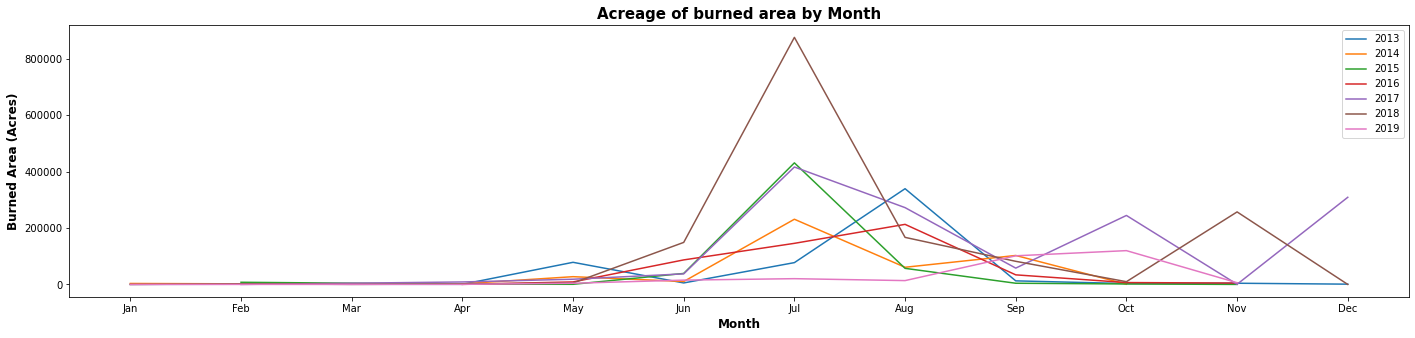

In [17]:
# Generating line chart for each year 
groub_month_2013 = fire_trend_2013.groupby('Started Month')
arces_per_month_2013 = groub_month_2013['AcresBurned'].sum()
a_plot_2013, = plt.plot(arces_per_month_2013)

groub_month_2014 = fire_trend_2014.groupby('Started Month')
arces_per_month_2014 = groub_month_2014['AcresBurned'].sum()
a_plot_2014, = plt.plot(arces_per_month_2014)

groub_month_2015 = fire_trend_2015.groupby('Started Month')
arces_per_month_2015 = groub_month_2015['AcresBurned'].sum()
a_plot_2015, = plt.plot(arces_per_month_2015)

groub_month_2016 = fire_trend_2016.groupby('Started Month')
arces_per_month_2016 = groub_month_2016['AcresBurned'].sum()
a_plot_2016, = plt.plot(arces_per_month_2016)

groub_month_2017 = fire_trend_2017.groupby('Started Month')
arces_per_month_2017 = groub_month_2017['AcresBurned'].sum()
a_plot_2017, = plt.plot(arces_per_month_2017)

groub_month_2018 = fire_trend_2018.groupby('Started Month')
arces_per_month_2018 = groub_month_2018['AcresBurned'].sum()
a_plot_2018, = plt.plot(arces_per_month_2018)

groub_month_2019 = fire_trend_2019.groupby('Started Month')
arces_per_month_2019 = groub_month_2019['AcresBurned'].sum()
a_plot_2019, = plt.plot(arces_per_month_2019)

# Set xtick and legend
positions = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)
labels = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
plt.xticks(positions, labels)
plt.legend([a_plot_2013,a_plot_2014,a_plot_2015,a_plot_2016,a_plot_2017,a_plot_2018,a_plot_2019], 
            ['2013','2014','2015','2016','2017','2018','2019'], loc='best')

# Set image size
plt.rcParams["figure.figsize"] = (24,5)

# Set x/y label, title
plt.title(f'Acreage of burned area by Month', fontweight='bold', fontsize=15)
plt.xlabel('Month', fontweight='bold', fontsize=12)
plt.ylabel('Burned Area (Acres)', fontweight='bold', fontsize=12)

# Save chart to Images folder
plt.savefig('Images/PatternbyMonth_arces.png')

# Present the chart
plt.show()

# To close pyplot
plt.close()

### Correlation

In [61]:
# Drop Null from column of interest (resources: personnel involved, dozers, engines, water tenders)
per_inv_df = ca_fire_df.dropna(how='any', subset=['PersonnelInvolved'])
dozers_df = ca_fire_df.dropna(how='any', subset=['Dozers'])
eng_df = ca_fire_df.dropna(how='any', subset=['Engines'])
water_df = ca_fire_df.dropna(how='any', subset=['WaterTenders'])

### Correlation between Final Size Burned (acres) vs Time Burned (days)

To find out that size burned area increases when time burned increases

The correlation between burned area (acres) and burned days is 0.14141
The r-squared is: 0.019997568


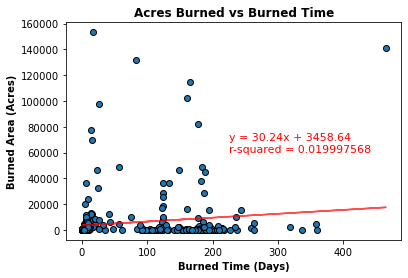

In [62]:
# Get data from dataframe to plot
area = final_burned_df.loc[(final_burned_df['Days Burned']>=0) & (final_burned_df['Days Burned']<1000), 'AcresBurned']
days = final_burned_df.loc[(final_burned_df['Days Burned']>=0) & (final_burned_df['Days Burned']<1000), 'Days Burned']

# Define x,y values
area_x_values = days
area_y_values = area

# Calculate the correlation
area_correlation = round(st.pearsonr(area_x_values, area_y_values)[0],5)
print(f"The correlation between burned area (acres) and burned days is {area_correlation}")

# Calculate linear regression values
(area_slope, area_intercept, area_rvalue, area_pvalue, area_stderr) = st.linregress(area_x_values, area_y_values)

# Calculate r-squared
area_r_squared = round(area_rvalue**2,9)
print(f"The r-squared is: {area_r_squared}")

# y = mx + b
area_regress_values = area_x_values * area_slope + area_intercept
area_line_eq = "y = " + str(round(area_slope,2)) + "x + " + str(round(area_intercept,2))

# Gernerate scatter chart with liner regression line, equation of line, r-squared value
plt.scatter(area_x_values, area_y_values, edgecolors='black')
plt.plot(area_x_values,area_regress_values, color='r', alpha=0.7)

# Plot the Annotation in the graph 
plt.annotate(area_line_eq,(225,70000), fontsize=11, color="red")
plt.annotate(f'r-squared = {area_r_squared}', (225,60000), fontsize=11, color="red")

# Define title and x/y labels
plt.title('Acres Burned vs Burned Time', fontweight='bold')
plt.xlabel('Burned Time (Days)', fontweight='bold')
plt.ylabel('Burned Area (Acres)', fontweight='bold')

# Save box plot graph to Images folder
plt.savefig('Images/day_area.png')

# Present the box plot chart
plt.show()

# To close pyplot
plt.close()

### Correlation between Resources vs Burned Time

To find out how many resources required to shorten burned time

#### Resources: Personnel Involved

The correlation between burned time (days) and personnel involved is 0.05
The r-squared is: 0.0028


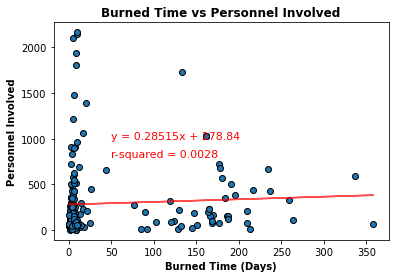

In [63]:
# Get data from dataframe to plot
per_inv_t = per_inv_df.loc[(per_inv_df['Days Burned']>=0) & (per_inv_df['Days Burned']<1000), 'PersonnelInvolved']
pt_days = per_inv_df.loc[(per_inv_df['Days Burned']>=0) & (per_inv_df['Days Burned']<1000), 'Days Burned']

# Define x, y values
pt_x_values = pt_days
pt_y_values = per_inv_t

# Calculate the correlation
pt_correlation = round(st.pearsonr(pt_x_values, pt_y_values)[0],2)
print(f"The correlation between burned time (days) and personnel involved is {pt_correlation}")

# Calculate linear regression values
(pt_slope, pt_intercept, pt_rvalue, pt_pvalue, pt_stderr) = st.linregress(pt_x_values, pt_y_values) 
                                                                                                   
# Calculate r-squared
pt_r_squared = round(pt_rvalue**2,5)
print(f"The r-squared is: {pt_r_squared}")

# y = mx + b
pt_regress_values = pt_x_values * pt_slope + pt_intercept
pt_line_eq = "y = " + str(round(pt_slope,5)) + "x + " + str(round(pt_intercept,2))

# Gernerate scatter chart with liner regression line, equation of line, r-squared value
plt.scatter(pt_x_values, pt_y_values, edgecolors='black')
plt.plot(pt_x_values,pt_regress_values, color='r', alpha=0.7)

# Plot the Annotation in the graph 
plt.annotate(pt_line_eq,(50,1000), fontsize=11, color="red")
plt.annotate(f'r-squared = {pt_r_squared}', (50,800), fontsize=11, color="red")

# Define title and x/y labels
plt.title('Burned Time vs Personnel Involved', fontweight='bold')
plt.xlabel('Burned Time (Days)', fontweight='bold')
plt.ylabel('Personnel Involved', fontweight='bold')

# Save box plot graph to Images folder
plt.savefig('Images/time_perinv.png')

# Present the box plot chart
plt.show()

# To close pyplot
plt.close()

#### Resources: Dozers

The correlation between burned time (days) and dozers is 0.06
The r-squared is: 0.00316


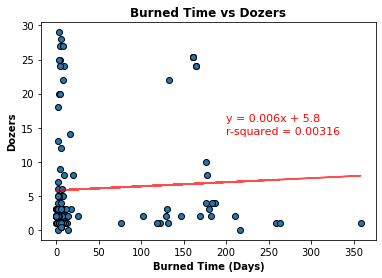

In [64]:
#Discover wheather dozers has relation to burned time
dozers_t = dozers_df.loc[(dozers_df['Days Burned']>=0) & (dozers_df['Days Burned']<1000), 'Dozers']
dt_days = dozers_df.loc[(dozers_df['Days Burned']>=0) & (dozers_df['Days Burned']<1000), 'Days Burned']

# Define x, y values
dt_x_values = dt_days
dt_y_values = dozers_t

# Calculate the correlation
dt_correlation = round(st.pearsonr(dt_x_values, dt_y_values)[0],2)
print(f"The correlation between burned time (days) and dozers is {dt_correlation}")

# Calculate linear regression values
(dt_slope, dt_intercept, dt_rvalue, dt_pvalue, dt_stderr) = st.linregress(dt_x_values, dt_y_values) 
                                                                                                   
# Calculate r-squared
dt_r_squared = round(dt_rvalue**2,5)
print(f"The r-squared is: {dt_r_squared}")

# y = mx + b
dt_regress_values = dt_x_values * dt_slope + dt_intercept
dt_line_eq = "y = " + str(round(dt_slope,5)) + "x + " + str(round(dt_intercept,2))

# Gernerate scatter chart with liner regression line, equation of line, r-squared value
plt.scatter(dt_x_values, dt_y_values, edgecolors='black')
plt.plot(dt_x_values, dt_regress_values, color='r', alpha=0.7)

# Plot the Annotation in the graph 
plt.annotate(dt_line_eq,(200,16), fontsize=11, color="red")
plt.annotate(f'r-squared = {dt_r_squared}', (200,14), fontsize=11, color="red")

# Define title and x/y labels
plt.title('Burned Time vs Dozers', fontweight='bold')
plt.xlabel('Burned Time (Days)', fontweight='bold')
plt.ylabel('Dozers', fontweight='bold')

# Save box plot graph to Images folder
plt.savefig('Images/time_dozers.png')

# Present the box plot chart
plt.show()

# To close pyplot
plt.close()

#### Resources: Engines

The correlation between burned time (days) and dozers is 0.06
The r-squared is: 0.00356


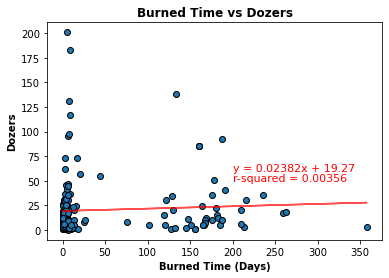

In [65]:
#Discover wheather dozers has relation to burned time
eng_t = eng_df.loc[(eng_df['Days Burned']>=0) & (eng_df['Days Burned']<1000), 'Engines']
et_days = eng_df.loc[(eng_df['Days Burned']>=0) & (eng_df['Days Burned']<1000), 'Days Burned']

# Define x, y values
et_x_values = et_days
et_y_values = eng_t

# Calculate the correlation
et_correlation = round(st.pearsonr(et_x_values, et_y_values)[0],2)
print(f"The correlation between burned time (days) and dozers is {et_correlation}")

# Calculate linear regression values
(et_slope, et_intercept, et_rvalue, et_pvalue, et_stderr) = st.linregress(et_x_values, et_y_values) 
                                                                                                   
# Calculate r-squared
et_r_squared = round(et_rvalue**2,5)
print(f"The r-squared is: {et_r_squared}")

# y = mx + b
et_regress_values = et_x_values * et_slope + et_intercept
et_line_eq = "y = " + str(round(et_slope,5)) + "x + " + str(round(et_intercept,2))

# Gernerate scatter chart with liner regression line, equation of line, r-squared value
plt.scatter(et_x_values, et_y_values, edgecolors='black')
plt.plot(et_x_values, et_regress_values, color='r', alpha=0.7)

# Plot the Annotation in the graph 
plt.annotate(et_line_eq,(200,60), fontsize=11, color="red")
plt.annotate(f'r-squared = {et_r_squared}', (200,50), fontsize=11, color="red")

# Define title and x/y labels
plt.title('Burned Time vs Dozers', fontweight='bold')
plt.xlabel('Burned Time (Days)', fontweight='bold')
plt.ylabel('Dozers', fontweight='bold')

# Save box plot graph to Images folder
plt.savefig('Images/time_engines.png')

# Present the box plot chart
plt.show()

# To close pyplot
plt.close()

#### Resources: Water Tenders

The correlation between burned time (days) and dozers is 0.0
The r-squared is: 2e-05


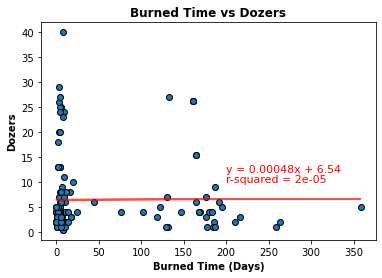

In [66]:
#Discover wheather dozers has relation to burned time
wt_t = water_df.loc[(water_df['Days Burned']>=0) & (water_df['Days Burned']<1000), 'WaterTenders']
wt_days = water_df.loc[(water_df['Days Burned']>=0) & (water_df['Days Burned']<1000), 'Days Burned']

# Define x, y values
wt_x_values = wt_days
wt_y_values = wt_t

# Calculate the correlation
wt_correlation = round(st.pearsonr(wt_x_values, wt_y_values)[0],2)
print(f"The correlation between burned time (days) and dozers is {wt_correlation}")

# Calculate linear regression values
(wt_slope, wt_intercept, wt_rvalue, wt_pvalue, wt_stderr) = st.linregress(wt_x_values, wt_y_values) 
                                                                                                   
# Calculate r-squared
wt_r_squared = round(wt_rvalue**2,5)
print(f"The r-squared is: {wt_r_squared}")

# y = mx + b
wt_regress_values = wt_x_values * wt_slope + wt_intercept
wt_line_eq = "y = " + str(round(wt_slope,5)) + "x + " + str(round(wt_intercept,2))

# Gernerate scatter chart with liner regression line, equation of line, r-squared value
plt.scatter(wt_x_values, wt_y_values, edgecolors='black')
plt.plot(wt_x_values, wt_regress_values, color='r', alpha=0.7)

# Plot the Annotation in the graph 
plt.annotate(wt_line_eq,(200,12), fontsize=11, color="red")
plt.annotate(f'r-squared = {wt_r_squared}', (200,10), fontsize=11, color="red")

# Define title and x/y labels
plt.title('Burned Time vs Dozers', fontweight='bold')
plt.xlabel('Burned Time (Days)', fontweight='bold')
plt.ylabel('Dozers', fontweight='bold')

# Save box plot graph to Images folder
plt.savefig('Images/time_water.png')

# Present the box plot chart
plt.show()

# To close pyplot
plt.close()

### Correlation between Resources vs Burned Area

To find out how many resources required to reduce area burned

#### Resources: Personnel Involved

The correlation between burned time (days) and personnel involved is 0.22
The r-squared is: 0.04867


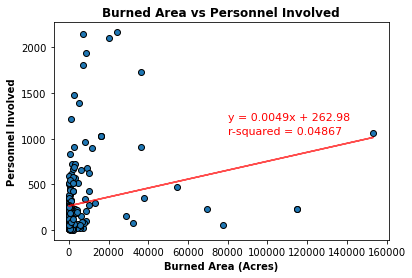

In [67]:
# Get data from dataframe to plot
per_inv_a = per_inv_df['PersonnelInvolved']
pa_days = per_inv_df['AcresBurned']

# Define x, y values
pa_x_values = pa_days
pa_y_values = per_inv_a

# Calculate the correlation
pa_correlation = round(st.pearsonr(pa_x_values, pa_y_values)[0],2)
print(f"The correlation between burned time (days) and personnel involved is {pa_correlation}")

# Calculate linear regression values
(pa_slope, pa_intercept, pa_rvalue, pa_pvalue, pa_stderr) = st.linregress(pa_x_values, pa_y_values) 
                                                                                                   
# Calculate r-squared
pa_r_squared = round(pa_rvalue**2,5)
print(f"The r-squared is: {pa_r_squared}")

# y = mx + b
pa_regress_values = pa_x_values * pa_slope + pa_intercept
pa_line_eq = "y = " + str(round(pa_slope,5)) + "x + " + str(round(pa_intercept,2))

# Gernerate scatter chart with liner regression line, equation of line, r-squared value
plt.scatter(pa_x_values, pa_y_values, edgecolors='black')
plt.plot(pa_x_values,pa_regress_values, color='r', alpha=0.7)

# Plot the Annotation in the graph 
plt.annotate(pa_line_eq,(80000,1200), fontsize=11, color="red")
plt.annotate(f'r-squared = {pa_r_squared}', (80000,1050), fontsize=11, color="red")

# Define title and x/y labels
plt.title('Burned Area vs Personnel Involved', fontweight='bold')
plt.xlabel('Burned Area (Acres)', fontweight='bold')
plt.ylabel('Personnel Involved', fontweight='bold')

# Save box plot graph to Images folder
plt.savefig('Images/area_perinv.png')

# Present the box plot chart
plt.show()

# To close pyplot
plt.close()

#### Resources: Dozers

The correlation between burned time (days) and dozers is 0.26
The r-squared is: 0.06742


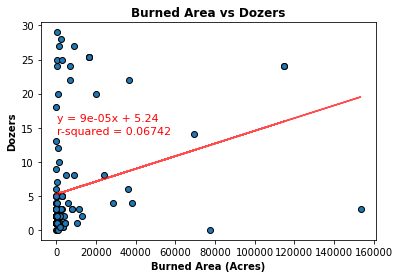

In [68]:
# Get data from dataframe to plot
dozers_a = dozers_df['Dozers']
da_days = dozers_df['AcresBurned']

# Define x, y values
da_x_values = da_days
da_y_values = dozers_a

# Calculate the correlation
da_correlation = round(st.pearsonr(da_x_values, da_y_values)[0],2)
print(f"The correlation between burned time (days) and dozers is {da_correlation}")

# Calculate linear regression values
(da_slope, da_intercept, da_rvalue, da_pvalue, dt_stderr) = st.linregress(da_x_values, da_y_values) 
                                                                                                   
# Calculate r-squared
da_r_squared = round(da_rvalue**2,5)
print(f"The r-squared is: {da_r_squared}")

# y = mx + b
da_regress_values = da_x_values * da_slope + da_intercept
da_line_eq = "y = " + str(round(da_slope,5)) + "x + " + str(round(da_intercept,2))

# Gernerate scatter chart with liner regression line, equation of line, r-squared value
plt.scatter(da_x_values, da_y_values, edgecolors='black')
plt.plot(da_x_values, da_regress_values, color='r', alpha=0.7)

# Plot the Annotation in the graph 
plt.annotate(da_line_eq,(200,16), fontsize=11, color="red")
plt.annotate(f'r-squared = {da_r_squared}', (200,14), fontsize=11, color="red")

# Define title and x/y labels
plt.title('Burned Area vs Dozers', fontweight='bold')
plt.xlabel('Burned Area (Acres)', fontweight='bold')
plt.ylabel('Dozers', fontweight='bold')

# Save box plot graph to Images folder
plt.savefig('Images/area_dozers.png')

# Present the box plot chart
plt.show()

# To close pyplot
plt.close()

#### Resources: Engines

The correlation between burned time (days) and dozers is 0.22
The r-squared is: 0.04741


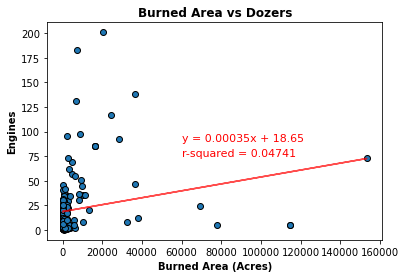

In [69]:
#Discover wheather dozers has relation to burned time
eng_a = eng_df['Engines']
ea_days = eng_df['AcresBurned']

# Define x, y values
ea_x_values = ea_days
ea_y_values = eng_a

# Calculate the correlation
ea_correlation = round(st.pearsonr(ea_x_values, ea_y_values)[0],2)
print(f"The correlation between burned time (days) and dozers is {ea_correlation}")

# Calculate linear regression values
(ea_slope, ea_intercept, ea_rvalue, ea_pvalue, ea_stderr) = st.linregress(ea_x_values, ea_y_values) 
                                                                                                   
# Calculate r-squared
ea_r_squared = round(ea_rvalue**2,5)
print(f"The r-squared is: {ea_r_squared}")

# y = mx + b
ea_regress_values = ea_x_values * ea_slope + ea_intercept
ea_line_eq = "y = " + str(round(ea_slope,5)) + "x + " + str(round(ea_intercept,2))

# Gernerate scatter chart with liner regression line, equation of line, r-squared value
plt.scatter(ea_x_values, ea_y_values, edgecolors='black')
plt.plot(ea_x_values, ea_regress_values, color='r', alpha=0.7)

# Plot the Annotation in the graph 
plt.annotate(ea_line_eq,(60000,90), fontsize=11, color="red")
plt.annotate(f'r-squared = {ea_r_squared}', (60000,75), fontsize=11, color="red")

# Define title and x/y labels
plt.title('Burned Area vs Dozers', fontweight='bold')
plt.xlabel('Burned Area (Acres)', fontweight='bold')
plt.ylabel('Engines', fontweight='bold')

# Save box plot graph to Images folder
plt.savefig('Images/area_engines.png')

# Present the box plot chart
plt.show()

# To close pyplot
plt.close()

#### Resources: Water Tenders

The correlation between burned time (days) and dozers is 0.17
The r-squared is: 0.02777


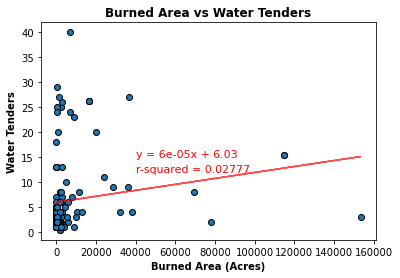

In [70]:
#Discover wheather dozers has relation to burned time
wt_a = water_df['WaterTenders']
wa_days = water_df['AcresBurned']

# Define x, y values
wa_x_values = wa_days
wa_y_values = wt_a

# Calculate the correlation
wa_correlation = round(st.pearsonr(wa_x_values, wa_y_values)[0],2)
print(f"The correlation between burned time (days) and dozers is {wa_correlation}")

# Calculate linear regression values
(wa_slope, wa_intercept, wa_rvalue, wa_pvalue, wa_stderr) = st.linregress(wa_x_values, wa_y_values) 
                                                                                                   
# Calculate r-squared
wa_r_squared = round(wa_rvalue**2,5)
print(f"The r-squared is: {wa_r_squared}")

# y = mx + b
wa_regress_values = wa_x_values * wa_slope + wa_intercept
wa_line_eq = "y = " + str(round(wa_slope,5)) + "x + " + str(round(wa_intercept,2))

# Gernerate scatter chart with liner regression line, equation of line, r-squared value
plt.scatter(wa_x_values, wa_y_values, edgecolors='black')
plt.plot(wa_x_values, wa_regress_values, color='r', alpha=0.7)

# Plot the Annotation in the graph 
plt.annotate(wa_line_eq,(40000,15), fontsize=11, color="red")
plt.annotate(f'r-squared = {wa_r_squared}', (40000,12), fontsize=11, color="red")

# Define title and x/y labels
plt.title('Burned Area vs Water Tenders', fontweight='bold')
plt.xlabel('Burned Area (Acres)', fontweight='bold')
plt.ylabel('Water Tenders', fontweight='bold')

# Save box plot graph to Images folder
plt.savefig('Images/area_water.png')

# Present the box plot chart
plt.show()

# To close pyplot
plt.close()

In [127]:
# Store latitude and longitude in locations
location_df = ca_fire_df.loc[(ca_fire_df['Latitude']>=-90) & (ca_fire_df['Latitude']<=90)
                             & (ca_fire_df['Longitude']>=-180) & (ca_fire_df['Longitude']<=180)]
locations = location_df[["Latitude", "Longitude"]]

# Fill NaN values and convert to float
burned_area = location_df["AcresBurned"].astype(float)

# Plot Heatmap
fig = gmaps.figure(center=(37, -118), zoom_level=5)

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=burned_area, 
                                 dissipating=True, max_intensity=5,
                                 point_radius=2)


# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))